## let the time stamp interact with the hidden; also include intermediate values in the criterion

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as stats
from collections import defaultdict
from itertools import product
from sklearn.metrics import mean_absolute_error as mae
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch import optim
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
look_back = 72
look_future = 36
batch_size = 512
linear_node = 8
aux_feature = 1

In [3]:
dat = pd.read_csv('train.csv', index_col='row_id')
def preprocess(dat):
    time_mapper = {}
    ii = 0
    for h in range(24):
        for mm in ['00','20','40']:
            hh = '{0:02d}'.format(h)
            time_mapper[hh+':'+mm] = ii
            ii += 1

    dat['unique'] = dat['x'].astype(str) + dat['y'].astype(str) + dat['direction']
    uniques = dat['unique'].unique()
    dat['day'] = pd.to_datetime(dat['time']).dt.weekday
    dat['time_stamp'] = dat['time'].apply(lambda x:time_mapper[x.split()[1][:5]])

    tmp = dat.groupby(['unique','day','time_stamp']).agg({'congestion':np.median})
    median_mapper = tmp.to_dict()['congestion']
    dat['median'] = dat.apply(lambda x: \
                              median_mapper[x['unique'],x['day'],x['time_stamp']], axis=1)
    dat['congestion-median'] = dat['congestion'] - dat['median']
    
    all_time = pd.DataFrame(pd.date_range('1991-04-01 00:00:00', '1991-09-30 11:40:00', freq='20Min'), columns=['time'])
    all_time['time'] = all_time['time'].astype(str)
    
    return uniques, median_mapper, time_mapper, all_time
uniques, median_mapper, time_mapper, all_time = preprocess(dat)

In [4]:
def getseries(unique):
    df = dat.loc[dat['unique']==unique, ['time', 'congestion-median']]
    df = pd.merge(all_time, df, left_on='time', right_on='time', how='outer')
    df = df.set_index('time')
    df['congestion-median'] = df['congestion-median'].fillna(0)
    ss = StandardScaler()
    df['congestion-median-normalized'] = ss.fit_transform(df['congestion-median'].values.reshape(-1,1)).reshape(-1)
    return df, ss

In [5]:
df,_ = getseries('00EB')

In [6]:
df

,congestion-median,congestion-median-normalized
time,,
1991-04-01 00:00:00,35.0,2.940104
1991-04-01 00:20:00,35.0,2.940104
1991-04-01 00:40:00,35.0,2.940104
1991-04-01 01:00:00,35.0,2.940104
1991-04-01 01:20:00,35.0,2.940104
...,...,...
1991-09-30 10:20:00,-7.0,-0.686983
1991-09-30 10:40:00,-6.0,-0.600624
1991-09-30 11:00:00,-7.0,-0.686983


In [7]:
test_periods = [
    ['1991-09-16 12:00:00', '1991-09-16 23:40:00'],
    ['1991-09-23 12:00:00', '1991-09-23 23:40:00']]
test_periods_with_lookback = []
for period in test_periods[:-1]:
    id1 = df.index.to_list().index(period[0])
    id1 = id1 - look_back
    id2 = df.index.to_list().index(period[1])
    print(id1, id2)

12060 12167


In [8]:
data_all = []
for unique in uniques:
    df, ss = getseries(unique)
    print(f"{unique} mean={ss.mean_} std={ss.scale_}")
    data_all.append(df['congestion-median-normalized'].values)
data_all = np.array(data_all).T

00EB mean=[0.95494673] std=[11.57954203]
00NB mean=[0.36636225] std=[9.43834367]
00SB mean=[0.80989346] std=[12.66415534]
01EB mean=[0.31270928] std=[7.16000315]
01NB mean=[0.11331811] std=[6.53057596]
01SB mean=[0.12480974] std=[7.07213222]
01WB mean=[0.26012177] std=[10.8716075]
02EB mean=[0.12138508] std=[6.3123022]
02NB mean=[0.15669711] std=[6.25850326]
02SB mean=[0.2347793] std=[8.23555054]
02WB mean=[0.0956621] std=[5.89026848]
03EB mean=[0.32686454] std=[7.61781946]
03NB mean=[0.24101979] std=[5.89126285]
03NE mean=[0.51894977] std=[9.24724971]
03SB mean=[0.15015221] std=[8.23375089]
03SW mean=[0.37062405] std=[8.7385283]
03WB mean=[0.46803653] std=[8.50870973]
10EB mean=[0.02876712] std=[9.83829155]
10NB mean=[0.2587519] std=[10.99340554]
10NE mean=[0.04977169] std=[10.48097301]
10SB mean=[0.71438356] std=[10.07367299]
10SW mean=[0.45890411] std=[12.1627388]
10WB mean=[0.24847793] std=[6.42334036]
11EB mean=[0.24847793] std=[11.18812672]
11NB mean=[0.15989346] std=[10.31832783

In [9]:
np.mean(np.abs(data_all),axis=0)

array([0.74411232, 0.73272271, 0.68885603, 0.70650511, 0.70109617,
       0.67383517, 0.74960597, 0.68615763, 0.70872866, 0.72023099,
       0.54429618, 0.7098277 , 0.67608307, 0.68949218, 0.71140665,
       0.67762519, 0.70539177, 0.72957873, 0.75421574, 0.75001872,
       0.74256784, 0.77176702, 0.69730754, 0.75876791, 0.75820543,
       0.7566877 , 0.7562145 , 0.71014627, 0.74341657, 0.69780795,
       0.73006704, 0.67474084, 0.72678479, 0.69155535, 0.71405506,
       0.72714093, 0.71903352, 0.7073827 , 0.71462659, 0.74097749,
       0.63829302, 0.69517138, 0.73482825, 0.75306975, 0.65182169,
       0.54222884, 0.46384315, 0.61690899, 0.43455064, 0.48547183,
       0.75334959, 0.72349838, 0.72191201, 0.59598206, 0.56287097,
       0.69432433, 0.69414838, 0.55741912, 0.69573555, 0.74706284,
       0.6647803 , 0.59038589, 0.56141425, 0.62309218, 0.73535998])

In [10]:
data_all.shape

(13140, 65)

In [11]:
stamped = (np.array(range(data_all.shape[0])) % 72).reshape(-1,1)
stamped = (stamped - 36.0) / 72.0
data_all_stamped = np.hstack((data_all,stamped))
data_all_stamped.shape

(13140, 66)

In [12]:
def create_dataset(dataset, look_back=72, look_future=36):
    ''' return shape (N,look_back,features), (N,look_future,features)'''
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-look_future+1):
        dataX.append(dataset[i:(i+look_back),:])
        dataY.append(dataset[i+1:i+look_back+look_future,:])
    return np.array(dataX), np.array(dataY)

In [13]:
def assemble(dat):
    train_loaders, test_loaders = [], []
    
    # for train/test
    train = dat[:id1]
#     test = dat[id1:id1+look_back+look_future,icol]
    test = dat[id1:]
    print(train.shape, test.shape)

    X, y = create_dataset(train, look_back=look_back, look_future=look_future)
    train_dataset = []
    for i in range(len(X)):
        train_dataset.append((torch.tensor(X[i],dtype=torch.float32),
                              torch.tensor(y[i],dtype=torch.float32)))
    train_loaders.append(DataLoader(train_dataset, batch_size=batch_size, drop_last=False, shuffle=True))

    X, y = create_dataset(test, look_back=look_back, look_future=look_future)
    test_dataset = []
    for i in range(len(X)):
        test_dataset.append((torch.tensor(X[i],dtype=torch.float32),
                             torch.tensor(y[i],dtype=torch.float32)))
    test_loaders.append(DataLoader(test_dataset, batch_size=batch_size, drop_last=False, shuffle=True))
    
    train = dat[:]
    X, y = create_dataset(train, look_back=look_back, look_future=look_future)
    train_dataset = []
    for i in range(len(X)):
        train_dataset.append((torch.tensor(X[i],dtype=torch.float32),
                              torch.tensor(y[i],dtype=torch.float32)))
    train_loaders.append(DataLoader(train_dataset, batch_size=batch_size, drop_last=False, shuffle=True))
        
    return train_loaders, test_loaders

In [14]:
train_loaders, test_loaders = assemble(data_all_stamped)

(12060, 66) (1080, 66)


In [15]:
X, y = next(iter(test_loaders[0]))
X.shape, y.shape

(torch.Size([512, 72, 66]), torch.Size([512, 107, 66]))

In [16]:
criterion = nn.L1Loss()
class MyModel(nn.Module):
    def __init__(self, input_feature, hidden_size, output_feature, aux_feature, num_layers=1):
        super(MyModel, self).__init__()
        self.linear = nn.Linear(input_feature, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers=num_layers, dropout=0.5)
        ''' 
            gru input is (L,N,H_in=H_hidden), hidden is (num_layers, h_hidden)
            output is (L,N,H_hidden), hidden is (num_layers, h_hidden)
        '''
        self.linear_aux = nn.Linear(aux_feature, hidden_size)
        self.linear_out = nn.Linear(2*hidden_size, output_feature)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = nn.Dropout(p=0.5)
    
    def forward(self, input, hidden):
        ''' 
            input is in the shape of (L,N,input_feature) 
            output is (L,N,out_feature)
            hidden is (num_layers, h_hidden)
            aux is (L,N,aux_feature)
        '''
#         output = F.relu(self.linear(input[:,:,:-aux_feature]))
        output = F.leaky_relu(self.linear(input[:,:,:-aux_feature]))
        output = self.dropout(output)
        output, hidden = self.gru(output, hidden)
        aux = self.linear_aux(input[:,:,-aux_feature:])
        aux = F.leaky_relu(aux)
        output = torch.cat((output, aux), axis=2)
#         output = self.linear_out(F.relu(output))
        output = self.linear_out(F.leaky_relu(output))
        return output, hidden
    
    def initHidden(self, batch_size):
        return torch.zeros((self.num_layers, batch_size, self.hidden_size))

In [17]:
X, y = next(iter(train_loaders[0]))
X.shape, y.shape

(torch.Size([512, 72, 66]), torch.Size([512, 107, 66]))

In [18]:
model = MyModel(65, linear_node, 65, 1, num_layers=3)
h0 = model.initHidden(len(X))
pred,_ = model.forward(X.transpose(0,1), h0)
pred.shape

torch.Size([72, 512, 65])

In [19]:
def evaluate(test_loader):
    ''' this estimate the loss on look future only '''
    model.eval()
    with torch.no_grad():
        
        curr_loss = 0
        L_total = look_back + look_future - 1
        
        for batch, (x, y) in enumerate(test_loader):
            
            N, L, _ = x.shape
            x = x.transpose(0,1)
            y = y.transpose(0,1)
            
            hidden = model.initHidden(N)
            output, hidden = model.forward(x, hidden)            
            loss = criterion(output[[-1],:,:], y[[L-1],:,:-aux_feature])
            output = torch.cat((output[[-1],:,:], y[[L-1],:,-aux_feature:]), axis=2) 
            
            for idx in range(L, L_total):                               
                output, hidden = model.forward(output, hidden)
                loss += criterion(output[[-1],:,:], y[[idx],:,:-aux_feature])
                output = torch.cat((output, y[[idx],:,-aux_feature:]), axis=2)                
                        
            loss /= look_future
            
            curr_loss += loss.item() * N
            
        curr_loss /= len(test_loader.dataset)
    return curr_loss

In [20]:
def train(n_epoches, train_loader, test_loader):
    optimizer = optim.Adam(model.parameters())

    best_test_loss = 100.0
    best_n_epoches = 0
    
    L_total = look_back + look_future - 1
    train_losses, test_losses = [], []    
    
    for epoch in range(n_epoches):

        curr_loss = 0.0

        model.train()
        
        w1 = 0.2
        w2 = 1.0 - w1

        for batch, (x, y) in enumerate(train_loader):
            
            # turn into (L,N,H+aux)
            N, L, _ = x.shape
            x = x.transpose(0,1)
            y = y.transpose(0,1)
            
            hidden = model.initHidden(N)
            output, hidden = model.forward(x, hidden)
            
            loss1 = criterion(output, y[:L,:,:-aux_feature])
            output = torch.cat((output[[-1],:,:], y[[L-1],:,-aux_feature:]), axis=2)  # shrink to length 1
            
            loss2 = 0
            for idx in range(L, L_total):
                output, hidden = model.forward(output, hidden)
                loss2 += criterion(output, y[[idx],:,:-aux_feature])
                output = torch.cat((output, y[[idx],:,-aux_feature:]), axis=2)                
            
            loss2 /= (look_future - 1)
#             print(f"{batch} {loss1} {loss2}")
            loss = loss1 * w1 + loss2 * w2

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            curr_loss += loss.item()*N

        curr_loss /= len(train_loader.dataset)
        
        test_loss = evaluate(test_loader)
        if (epoch % 1 == 0):  print(f'current {epoch} training loss={curr_loss} test loss = {test_loss}')
        if test_loss < best_test_loss and test_loss > curr_loss:
            best_n_epoches = epoch + 1
            best_test_loss = test_loss
            print(f'updating best loss {best_n_epoches} training loss={curr_loss} test loss = {test_loss}')
            
        train_losses.append(curr_loss)
        test_losses.append(test_loss)

        if epoch > best_n_epoches + 50:
            print(f'early stop {epoch} {best_n_epoches}')
            break
            
    return best_n_epoches, train_losses, test_losses

In [21]:
n_features = data_all_stamped.shape[1] - aux_feature

train_loaders, test_loaders = assemble(data_all_stamped)

model = MyModel(n_features, linear_node, n_features, aux_feature, num_layers=3)    
best_n_epoches, train_losses, test_losses  = train(500, train_loaders[0], test_loaders[0])
torch.save({'best_epoches': best_n_epoches,
            'model': model.state_dict()},
            'model_tmp.pickle')

(12060, 66) (1080, 66)
current 0 training loss=0.7143268158602772 test loss = 0.7235697266499284
updating best loss 1 training loss=0.7143268158602772 test loss = 0.7235697266499284
current 1 training loss=0.6937028959756275 test loss = 0.7115592963281417
updating best loss 2 training loss=0.6937028959756275 test loss = 0.7115592963281417
current 2 training loss=0.6830360411121628 test loss = 0.7036327824440669
updating best loss 3 training loss=0.6830360411121628 test loss = 0.7036327824440669
current 3 training loss=0.6773271860961065 test loss = 0.7006731256919186
updating best loss 4 training loss=0.6773271860961065 test loss = 0.7006731256919186
current 4 training loss=0.6752190770369279 test loss = 0.699051932342741
updating best loss 5 training loss=0.6752190770369279 test loss = 0.699051932342741
current 5 training loss=0.6739829469752353 test loss = 0.6981819465618584
updating best loss 6 training loss=0.6739829469752353 test loss = 0.6981819465618584
current 6 training loss=0

current 76 training loss=0.6656661347286538 test loss = 0.6982309955487148
current 77 training loss=0.6656587350361518 test loss = 0.6982144763021283
current 78 training loss=0.6656214234111479 test loss = 0.6990256918420037
current 79 training loss=0.6655876239273804 test loss = 0.6996404379146808
current 80 training loss=0.6655330331636893 test loss = 0.6993275115080753
current 81 training loss=0.6654519514639408 test loss = 0.6993012649427337
current 82 training loss=0.6654589516163311 test loss = 0.698584198829204
current 83 training loss=0.6654910563544969 test loss = 0.6985683220018464
current 84 training loss=0.665403258169205 test loss = 0.6999384849069052
current 85 training loss=0.665376927766263 test loss = 0.699807286630064
early stop 85 34


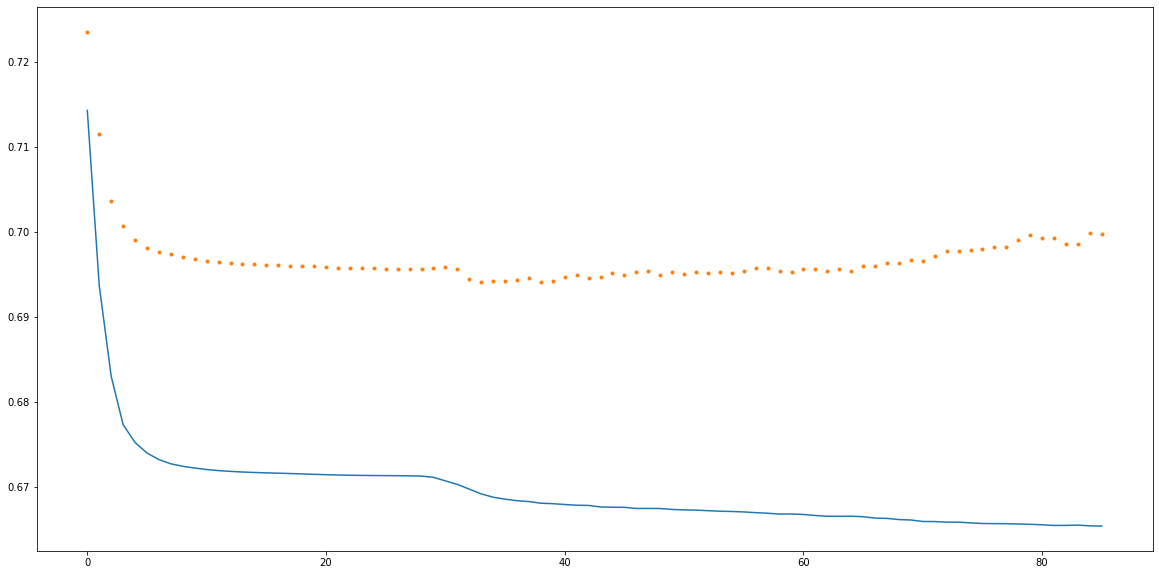

In [22]:
plt.figure(figsize=(20,10))
plt.plot(train_losses)
plt.plot(test_losses,'.')

In [26]:
def retrain(n_epoches, train_loader):
    optimizer = optim.Adam(model.parameters())

    L_total = look_back + look_future - 1
    
    for epoch in range(n_epoches):

        model.train()
        
        w1 = 0.2
        w2 = 1.0 - w1
        curr_loss = 0.0
        
        for batch, (x, y) in enumerate(train_loader):
            
            # turn into (L,N,H+aux)
            N, L, _ = x.shape
            x = x.transpose(0,1)
            y = y.transpose(0,1)
            
            hidden = model.initHidden(N)
            output, hidden = model.forward(x, hidden)
            
            loss1 = criterion(output, y[:L,:,:-aux_feature])
            output = torch.cat((output[[-1],:,:], y[[L-1],:,-aux_feature:]), axis=2)  # shrink to length 1
            
            loss2 = 0
            for idx in range(L, L_total):
                output, hidden = model.forward(output, hidden)
                loss2 += criterion(output, y[[idx],:,:-aux_feature])
                output = torch.cat((output, y[[idx],:,-aux_feature:]), axis=2)                
            
            loss2 /= (look_future - 1)
#             print(f"{batch} {loss1} {loss2}")
            loss = loss1 * w1 + loss2 * w2

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            curr_loss += loss.item()*N

        curr_loss /= len(train_loader.dataset)
        print(f"{epoch} {curr_loss}")
            
    return curr_loss

In [27]:
model = MyModel(n_features, linear_node, n_features, aux_feature, num_layers=3)
best_n_epoches = 40
loss = retrain(best_n_epoches, train_loaders[1])
torch.save({'loss': loss,
            'best_epoches': best_n_epoches,
            'model': model.state_dict()},
            'model_allgru_withforward.pickle')

0 0.7047663000148959
1 0.6865815300993786
2 0.67953211213168
3 0.6770852060006273
4 0.6759081741602434
5 0.675119525983988
6 0.6744851542069799
7 0.6739088946033456
8 0.6733776083025848
9 0.6729839766856981
10 0.6726446684484497
11 0.6723879429610411
12 0.6721419370623513
13 0.6719301775147011
14 0.6717191735552798
15 0.6715872390102117
16 0.6714782203999062
17 0.6713295539579945
18 0.6712051197654368
19 0.6710695322509519
20 0.6709595157739199
21 0.6708313692999958
22 0.6707706596574569
23 0.6706289791561441
24 0.6705282394814489
25 0.6704168028836238
26 0.6703416685649003
27 0.6702801224221878
28 0.6701360136432878
29 0.6701003574615226
30 0.6699750647160333
31 0.6699649521955678
32 0.6698438209500617
33 0.6697299712216288


In [29]:
test_data = pd.read_csv('test.csv')

In [30]:
test_data

,row_id,time,x,y,direction
0,848835,1991-09-30 12:00:00,0,0,EB
1,848836,1991-09-30 12:00:00,0,0,NB
2,848837,1991-09-30 12:00:00,0,0,SB
3,848838,1991-09-30 12:00:00,0,1,EB
4,848839,1991-09-30 12:00:00,0,1,NB
...,...,...,...,...,...
2335,851170,1991-09-30 23:40:00,2,3,NB
2336,851171,1991-09-30 23:40:00,2,3,NE
2337,851172,1991-09-30 23:40:00,2,3,SB
2338,851173,1991-09-30 23:40:00,2,3,SW


In [35]:
data_all_stamped[-1]*72

array([  99.76593483,   12.46213551,   12.45149534,   -3.14456125,
        -78.42476797,  -72.53629954,   24.76829971,  -47.00974643,
          9.70165001,  102.85844114,  -37.83998505,  233.19872091,
        -88.49603863,  -27.39889064,   -1.31300534,  -44.25057841,
        -71.65582677,  -14.8472153 ,  -40.99095003,   27.13645366,
          2.04139876,  -20.47574152,  -13.99434032,  -14.46984066,
         19.81790796,  -62.73061403,  -24.30130162,   57.1685019 ,
         80.2105583 ,  -32.59077629,   28.65381075,   22.79970429,
          6.54603724,  -74.63413326,   37.55955944,   88.61713853,
         -0.71580701,   41.63134479,  -12.46919076,  -86.0836378 ,
        -38.14524228,  -63.81481951,  -87.26763706,  -44.19114773,
         16.06464768,  -53.22334233,    5.93157532,    7.92131351,
       -168.30139941,  -77.9612408 ,   58.52679341,   -2.02790319,
        -26.48740766,   18.15399731,  -19.0835262 ,   -1.23156399,
        107.50470201,  -44.34042406,  -22.60572845,  -13.10798

In [58]:
test_all_stamped = np.zeros((36, 66))
test_all_stamped[:,-1] = (np.arange(36,72) - 36)/72
test_all_stamped[1]*72

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])

In [59]:
data_all_stamped.shape

(13140, 66)

In [68]:
model.eval()
with torch.no_grad():

    L = look_back
    x = torch.tensor(data_all_stamped[-look_back:], dtype=torch.float32).reshape(1,L,-1)
    N = 1
    
    x = x.transpose(0,1)
    hidden = model.initHidden(N)
    output, hidden = model.forward(x, hidden)

    for idx in range(len(test_all_stamped)):
        test_all_stamped[idx,:65] = output[[-1]]
        x = torch.tensor(test_all_stamped[idx], dtype=torch.float32).reshape(1,1,-1)
        x = x.transpose(0,1)
        output, hidden = model.forward(x, hidden)

In [69]:
test_all_stamped

array([[-0.10270856, -0.08321459, -0.09457718, ..., -0.214037  ,
        -0.02869929,  0.        ],
       [-0.0974922 , -0.07287836, -0.08720264, ..., -0.21415952,
        -0.02698988,  0.01388889],
       [-0.09273058, -0.06334323, -0.08033958, ..., -0.21415226,
        -0.02528247,  0.02777778],
       ...,
       [-0.07882339, -0.03822891, -0.06258969, ..., -0.21354599,
        -0.02053973,  0.45833333],
       [-0.07884546, -0.03835919, -0.06267674, ..., -0.21354803,
        -0.02055113,  0.47222222],
       [-0.07886579, -0.03848609, -0.06276135, ..., -0.21355011,
        -0.02056184,  0.48611111]])

In [74]:
test_all = np.zeros((test_all_stamped.shape[0], test_all_stamped.shape[1]-1))
for icol,unique in enumerate(uniques):
    _, ss = getseries(unique)
    print(icol, ss.mean_, ss.scale_)
    test_all[:,icol] = ss.inverse_transform(test_all_stamped[:,icol].reshape(-1,1)).reshape(-1)

0 [0.95494673] [11.57954203]
1 [0.36636225] [9.43834367]
2 [0.80989346] [12.66415534]
3 [0.31270928] [7.16000315]
4 [0.11331811] [6.53057596]
5 [0.12480974] [7.07213222]
6 [0.26012177] [10.8716075]
7 [0.12138508] [6.3123022]
8 [0.15669711] [6.25850326]
9 [0.2347793] [8.23555054]
10 [0.0956621] [5.89026848]
11 [0.32686454] [7.61781946]
12 [0.24101979] [5.89126285]
13 [0.51894977] [9.24724971]
14 [0.15015221] [8.23375089]
15 [0.37062405] [8.7385283]
16 [0.46803653] [8.50870973]
17 [0.02876712] [9.83829155]
18 [0.2587519] [10.99340554]
19 [0.04977169] [10.48097301]
20 [0.71438356] [10.07367299]
21 [0.45890411] [12.1627388]
22 [0.24847793] [6.42334036]
23 [0.24847793] [11.18812672]
24 [0.15989346] [10.31832783]
25 [0.34117199] [8.4259399]
26 [0.18546423] [9.437907]
27 [-0.01628615] [7.57712006]
28 [0.3239726] [8.68556444]
29 [-0.03120244] [10.97713726]
30 [0.00715373] [7.52028878]
31 [-0.19923896] [10.10299092]
32 [0.17343988] [9.091352]
33 [0.26263318] [7.97101223]
34 [0.05106545] [7.5699

In [73]:
test_all

array([[-0.2343714 , -0.41904563, -0.38784662, ..., -0.00361996,
        -0.00559777, -0.07679954],
       [-0.17396825, -0.32148876, -0.2944543 , ..., -0.00228128,
        -0.0065993 , -0.05872599],
       [-0.11883094, -0.23149289, -0.20753948, ..., -0.00096375,
        -0.00653998, -0.04067371],
       ...,
       [ 0.042208  ,  0.00554462,  0.0172479 , ...,  0.00434741,
        -0.00158399,  0.00947099],
       [ 0.04195237,  0.00431499,  0.01614545, ...,  0.00435899,
        -0.00160067,  0.00935046],
       [ 0.04171701,  0.00311735,  0.01507395, ...,  0.00437086,
        -0.00161761,  0.00923718]])

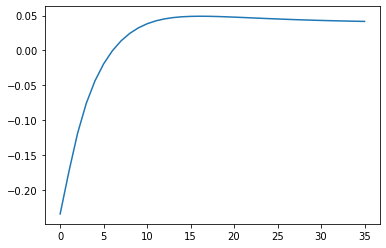

In [75]:
plt.plot(test_all[:,0])

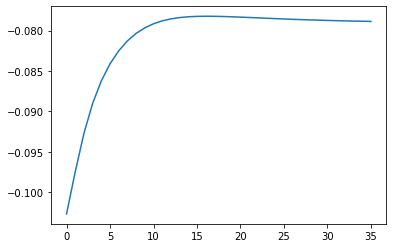

In [76]:
plt.plot(test_all_stamped[:,0])

In [77]:
def preprocess_test(dat):
    dat['unique'] = dat['x'].astype(str) + dat['y'].astype(str) + dat['direction']
    dat['day'] = pd.to_datetime(dat['time']).dt.weekday
    dat['time_stamp'] = dat['time'].apply(lambda x:time_mapper[x.split()[1][:5]])

    dat['median'] = dat.apply(lambda x: \
                              median_mapper[x['unique'],x['day'],x['time_stamp']], axis=1)

In [79]:
preprocess_test(test_data)

In [80]:
test_data

,row_id,time,x,y,direction,unique,day,time_stamp,median
0,848835,1991-09-30 12:00:00,0,0,EB,00EB,0,36,47.0
1,848836,1991-09-30 12:00:00,0,0,NB,00NB,0,36,35.0
2,848837,1991-09-30 12:00:00,0,0,SB,00SB,0,36,56.5
3,848838,1991-09-30 12:00:00,0,1,EB,01EB,0,36,22.0
4,848839,1991-09-30 12:00:00,0,1,NB,01NB,0,36,72.0
...,...,...,...,...,...,...,...,...,...
2335,851170,1991-09-30 23:40:00,2,3,NB,23NB,0,71,68.0
2336,851171,1991-09-30 23:40:00,2,3,NE,23NE,0,71,25.0
2337,851172,1991-09-30 23:40:00,2,3,SB,23SB,0,71,71.0
2338,851173,1991-09-30 23:40:00,2,3,SW,23SW,0,71,11.0


In [81]:
test_uniques = {}

for icol,unique in enumerate(uniques):

    print(f"doing {unique}")
    _, ss = getseries(unique)
    print(ss.mean_, ss.scale_)
    ys = ss.inverse_transform(test_all_stamped[:,icol].reshape(1,-1)).reshape(-1)
    test_unique = test_data[test_data['unique']==unique].copy()
    test_unique['to_add'] = ys
    test_unique['congestion'] = test_unique['median'] + test_unique['to_add']
#     test_unique['congestion'] = test_unique['median']

    test_uniques[unique] = test_unique.set_index('time')

doing 00EB
[0.95494673] [11.57954203]
doing 00NB
[0.36636225] [9.43834367]
doing 00SB
[0.80989346] [12.66415534]
doing 01EB
[0.31270928] [7.16000315]
doing 01NB
[0.11331811] [6.53057596]
doing 01SB
[0.12480974] [7.07213222]
doing 01WB
[0.26012177] [10.8716075]
doing 02EB
[0.12138508] [6.3123022]
doing 02NB
[0.15669711] [6.25850326]
doing 02SB
[0.2347793] [8.23555054]
doing 02WB
[0.0956621] [5.89026848]
doing 03EB
[0.32686454] [7.61781946]
doing 03NB
[0.24101979] [5.89126285]
doing 03NE
[0.51894977] [9.24724971]
doing 03SB
[0.15015221] [8.23375089]
doing 03SW
[0.37062405] [8.7385283]
doing 03WB
[0.46803653] [8.50870973]
doing 10EB
[0.02876712] [9.83829155]
doing 10NB
[0.2587519] [10.99340554]
doing 10NE
[0.04977169] [10.48097301]
doing 10SB
[0.71438356] [10.07367299]
doing 10SW
[0.45890411] [12.1627388]
doing 10WB
[0.24847793] [6.42334036]
doing 11EB
[0.24847793] [11.18812672]
doing 11NB
[0.15989346] [10.31832783]
doing 11SB
[0.34117199] [8.4259399]
doing 11WB
[0.18546423] [9.437907]
do

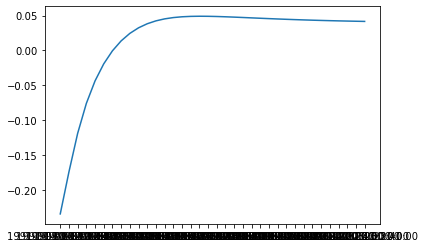

In [83]:
plt.plot(test_uniques['00EB']['to_add'])

In [84]:
test_data['congestion'] = 0.0
for idx in test_data.index:
    unique, time = test_data.at[idx,'unique'], test_data.at[idx,'time']
    test_data.at[idx,'congestion'] = test_uniques[unique].at[time,'congestion']

In [85]:
test_data

,row_id,time,x,y,direction,unique,day,time_stamp,median,congestion
0,848835,1991-09-30 12:00:00,0,0,EB,00EB,0,36,47.0,46.765629
1,848836,1991-09-30 12:00:00,0,0,NB,00NB,0,36,35.0,34.580954
2,848837,1991-09-30 12:00:00,0,0,SB,00SB,0,36,56.5,56.112153
3,848838,1991-09-30 12:00:00,0,1,EB,01EB,0,36,22.0,21.407363
4,848839,1991-09-30 12:00:00,0,1,NB,01NB,0,36,72.0,71.453418
...,...,...,...,...,...,...,...,...,...,...
2335,851170,1991-09-30 23:40:00,2,3,NB,23NB,0,71,68.0,68.002640
2336,851171,1991-09-30 23:40:00,2,3,NE,23NE,0,71,25.0,24.999160
2337,851172,1991-09-30 23:40:00,2,3,SB,23SB,0,71,71.0,71.004371
2338,851173,1991-09-30 23:40:00,2,3,SW,23SW,0,71,11.0,10.998382


In [86]:
test_data[['row_id','congestion']].to_csv('submission_allatonce_gru_withforward.csv', index=False)